# Figure 5: part 2

In this script, 5hmC is studied from a bin-by-bin level. The genome is broken into bins of approximately 1kb. The average 5hmC% of these bins is used to produce genome-wide mean and then individual bins are compared against this to produce a log2 difference. This is done in a non-strand-specific manner. 

Having identified this, these bins will then be studied for feature content using pybedtools. Each bin effectively represents a region in a bed file, and can be intersected against another bed file containing feature elements. This will help to identify preferentiality between feature types for 5hmC. The null hypothesis posits that 5hmC is distributed randomly across bins, and is not preferentially associated with any particular gene feature.  

In [43]:
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth

dry = True

if dry == True:
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))
    del nano_mc_df
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))

else:
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))
    del nano_mc_df
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))

In [2]:
import genomicranges as gr
import pandas as pd
import numpy as np 

def makeGenomicRange(df):
    df["seqnames"] = df["chromosome"]
    df["starts"] = df["chromStart"]
    df["ends"] = df["chromEnd"]

    df = df[["seqnames", "starts", "ends", "percentMeth"]]

    return gr.fromPandas(df)

def averageByBin(genomic_range):
    lengths = pd.read_csv('./feature_references/mm39.chrom.sizes', sep="\t", names=["lengths"]).to_dict()
    tiles = gr.tileGenome(lengths["lengths"], width=1000)
    return genomic_range.binnedAverage("percentMeth", tiles, "mean5hmC")

def modGRs():
    nano_gr = makeGenomicRange(nano_hmc_df)
    tab_gr = makeGenomicRange(tab_df)
    return nano_gr, tab_gr

def stripNaNs(df):
    df = df.loc[np.isnan(df["mean5hmC"]) != True]
    return df

def log2vMean(df):
    genome_wide_mean = df["mean5hmC"].mean()
    value = np.log2(
        np.divide(df["mean5hmC"], genome_wide_mean))
    return value

def main():
    nano_bin_avg, tab_bin_avg = map(averageByBin, modGRs())
    nano_bin_df = nano_bin_avg.toPandas()
    tab_bin_df = tab_bin_avg.toPandas()

    nano_bin_df, tab_bin_df = map(stripNaNs, [nano_bin_df, tab_bin_df])
    
    nano_bin_df, tab_bin_df = map(log2vMean, [nano_bin_df, tab_bin_df])
    
    return nano_bin_df, tab_bin_df

In [47]:
tab_eg_avg["mean5hmC"].min()
tab_df.loc[(tab_df["chromStart"] >= 3050001) & (tab_df["chromStart"] <= 3051000), "percentMeth"].mean()

0.625

In [40]:
tab_eg_avg.loc[tab_eg_avg["mean5hmC"] == tab_eg_avg["mean5hmC"].min()]

,seqnames,starts,ends,strand,mean5hmC
3057,chr1,3057001,3058000,*,5.263158
3096,chr1,3096001,3097000,*,5.263158
3128,chr1,3128001,3129000,*,5.263158
3143,chr1,3143001,3144000,*,5.263158
3152,chr1,3152001,3153000,*,5.263158
...,...,...,...,...,...
71837,chr1,71837001,71838000,*,5.263158
71895,chr1,71895001,71896000,*,5.263158
71911,chr1,71911001,71912000,*,5.263158
72731,chr1,72731001,72732000,*,5.263158


/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/genomicranges/GenomicRanges.py:1346: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in tgt_groups:
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/genomicranges/GenomicRanges.py:1373: RuntimeWarning: invalid value encountered in scalar divide
  vec_mean = np.sum(vec) / np.count_nonzero(vec)


<Axes: >

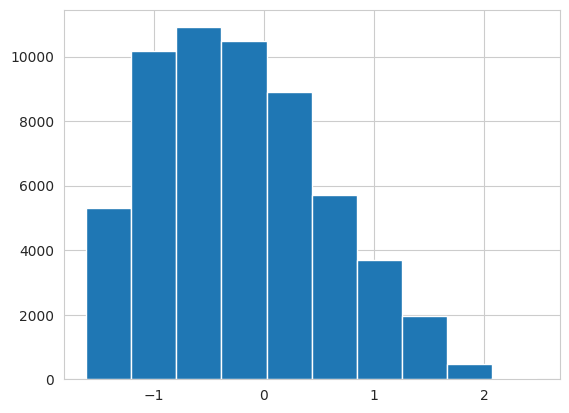

In [30]:
tab_eg_gr = gr.fromPandas(tab_df)
tab_eg_avg = averageByBin(tab_eg_gr)
tab_eg_avg.toPandas()

In [36]:
tab_bin_df["mean5hmC"].mean()

16.11107275586534

In [3]:
nano_bin_df, tab_bin_df = main()

/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/genomicranges/GenomicRanges.py:1346: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in tgt_groups:
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/genomicranges/GenomicRanges.py:1373: RuntimeWarning: invalid value encountered in scalar divide
  vec_mean = np.sum(vec) / np.count_nonzero(vec)
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/genomicranges/GenomicRanges.py:1346: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in tgt_groups:
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/py

In [4]:
def log2vMean(df):
    genome_wide_mean = df["mean5hmC"].mean()
    value = np.log2(
        np.divide(df["mean5hmC"], genome_wide_mean))
    return value

nano_bin_df["log2FromMean"], tab_bin_df["log2FromMean"] = map(log2vMean, [nano_bin_df, tab_bin_df])
all_bin_df = pd.merge(nano_bin_df, tab_bin_df, "inner", ["seqnames", "starts", "ends", "strand"], suffixes=["_Nanopore", "_TAB"])

<Axes: >

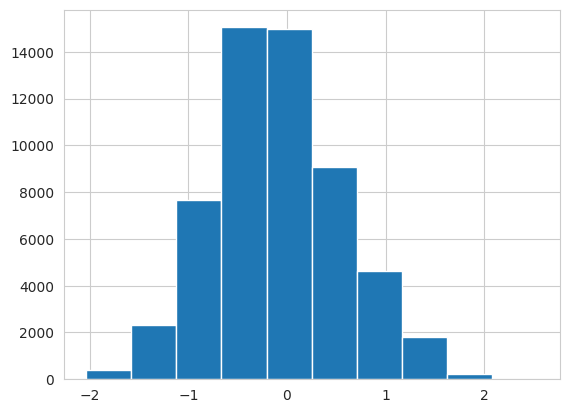

In [24]:
all_bin_df["log2FromMean_Nanopore"].hist()

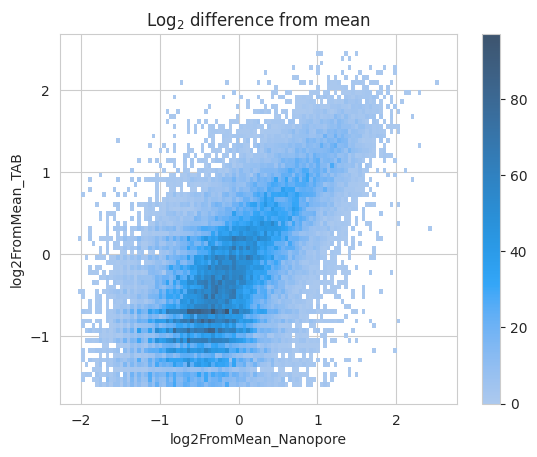

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig = plt.figure()

ax1 = fig.add_subplot()

sns.histplot(all_bin_df, x= "log2FromMean_Nanopore", y="log2FromMean_TAB", ax=ax1, cbar=True)
ax1.set_title("Log$_{2}$ difference from mean")

fig.show()